In [19]:
import pandas as pd
import numpy as np

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
USE_PCA = False

In [22]:
if USE_PCA:
    pca_prefix = 'pca_'
    pca_sufix = '_pca'
else:
    pca_prefix = ''
    pca_sufix = ''

df = pd.read_csv(f'datasets/train_set{pca_sufix}.csv')
test_df = pd.read_csv(f'datasets/test_set{pca_sufix}.csv')

if USE_PCA:
    X = df.loc[:, 'pca_0':]
else:
    X = df.loc[:, 'month':]
    
y = df['cpi_pct']
X_shuffled = df.sample(frac=1).loc[:, X.columns]
X_test = test_df.loc[:, X.columns]

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression

In [24]:
model = LinearRegression()

model.fit(X, y)

pred = model.predict(X_test)

pd.DataFrame(pred, index=X_test.index, columns=['pred']).to_csv(f'predictions/{pca_prefix}ols.csv') 

In [25]:
model = Lasso(max_iter=3000)

params = {
    'alpha': np.logspace(-8, -0.5, 100).tolist()
}

cv = GridSearchCV(model, params, cv=10)
cv.fit(X, y)

print(cv.best_estimator_)

pred = cv.predict(X_test)

pd.DataFrame(pred, index=X_test.index, columns=['pred']).to_csv(f'predictions/{pca_prefix}lasso_cv.csv')

Lasso(alpha=0.0002477076355991714, max_iter=3000)


In [26]:
model = Ridge()

params = {
    'alpha': np.linspace(1, 10000, 100).tolist()
}

cv = GridSearchCV(model, params, cv=10)
cv.fit(X, y)

print(cv.best_estimator_)

pred = cv.predict(X_test)

pd.DataFrame(pred, index=X_test.index, columns=['pred']).to_csv(f'predictions/{pca_prefix}ridge_cv.csv')

Ridge(alpha=506.0)


In [27]:
# shuffle Train dataset for CV

In [28]:
model = Lasso(max_iter=3000)

params = {
    'alpha': np.logspace(-8, -0.5, 100).tolist()
}

cv = GridSearchCV(model, params, cv=10)
cv.fit(X_shuffled, y)

print(cv.best_estimator_)

pred = cv.predict(X_test)

pd.DataFrame(pred, index=X_test.index, columns=['pred']).to_csv(f'predictions/{pca_prefix}lasso_cvshuffled.csv')

Lasso(alpha=0.00041803449618514534, max_iter=3000)


In [29]:
lasso_cv_coefs = pd.DataFrame(cv.best_estimator_.coef_, index=cv.feature_names_in_, columns=['coef'])
lasso_cv_coefs.to_csv('models/lasso_cv_coefs.csv')

# Coeficients chosen by our best model Shuffled Lasso CV

In [30]:
lasso_cv_coefs[lasso_cv_coefs.coef != 0]

,coef
cpi_50ema,0.00012


# Plotting Model Predictions

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for a nicer color palette

# Set a seaborn style
sns.set(style="whitegrid")

# Deep, muted, and bright are good choices for a color palette
colors = sns.color_palette("deep")

In [32]:
whole_data = pd.read_pickle('datasets/whole_dataset.pkl')

In [36]:
whole_data['lassoCV_pred'] = cv.predict(whole_data.loc[:, X.columns])

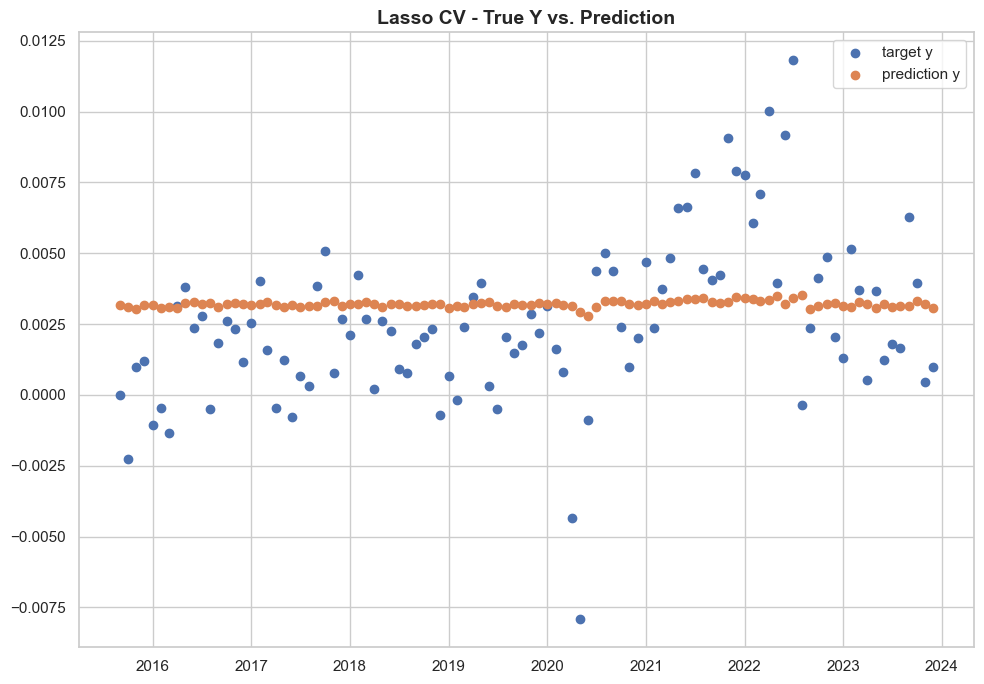

In [42]:
plot_data = whole_data.iloc[-100:, :]


# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 1, figsize=(10, 7))

# Plot the first graph on the left
axs.scatter(plot_data.index, plot_data['cpi_pct'], color=colors[0], label='target y')
axs.scatter(plot_data.index, plot_data['lassoCV_pred'], color=colors[1], label='prediction y')
axs.set_title('Lasso CV - True Y vs. Prediction', fontsize=14, fontweight='bold')
axs.legend()
axs.grid(True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.savefig('plots/predictions.png', dpi=300)